<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1pLsegkAICL9PzOLyAeH9DmDOBfktte0l8JW75uWcTng). 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import csr_matrix, csc_matrix, hstack as shstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from boruta import BorutaPy
import matplotlib.pyplot as plt

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../data/raw'
PATH_TO_SUBMISSIONS = '../kaggle_submissions'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [5]:
train_test_df = pd.concat([train_df, test_df], sort=False)

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [7]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [9]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [10]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [11]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [12]:
def sparsify_data(X, verbose=False):
    data = []
    row_ind = []
    col_ind = []
    max_site_ID = 0
    #split user site IDs into sessions and construct a sparse matrix of ID counts in a session
    for row_idx, row in enumerate(X.values):
        for site_ID in row:
            if site_ID > max_site_ID:
                max_site_ID = site_ID
            row_ind.append(row_idx)
            col_ind.append(site_ID) #site IDs can also serve as column indices, because they range from 0 to something
            data.append(1)
    X_sparse = csr_matrix((data, (row_ind, col_ind)), shape=(X.shape[0], max_site_ID+1), dtype=np.int64)
    return X_sparse[:, 1:] #exclude site ID 0

In [13]:
train_test_sparse = sparsify_data(train_test_df_sites)
X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = train_test_sparse[len(train_df):]
y = train_df['target'].values

**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [14]:
print( ' '.join(map(str, X_train_sparse.shape + X_test_sparse.shape)) )

253561 48371 82797 48371


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [15]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [16]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

**Создайте объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=17. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [17]:
sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

**Сделайте прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.**

In [18]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:, 1]

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [19]:
round(roc_auc_score(y_valid, logit_valid_pred_proba), 3)

0.934

**Сделайте прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [20]:
%%time
sgd_logit = SGDClassifier(loss='log', random_state=17).fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:, 1]

Wall time: 355 ms


**Запишите ответы в файл и сделайте посылку на Kaggle. Дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] Coursera_Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить.**

In [21]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [22]:
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'SGDClassifier_baseline.csv'))

---

## Улучшения

### Бейзлайн, подбор параметров с помощью GridSearchCV

In [23]:
def plot_validation_curves(param_values, grid_cv_results_, scale='linear'):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    print('valid_std: {}'.format(max(zip(valid_mu, valid_std), key=lambda x: x[0])[1]))
    if scale == 'linear':
        train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
        valid_line = plt.plot(param_values, valid_mu, '-', label='valid', color='red')
    if scale == 'log':
        train_line = plt.semilogx(param_values, train_mu, '-', label='train', color='green')
        valid_line = plt.semilogx(param_values, valid_mu, '-', label='valid', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [24]:
tss = TimeSeriesSplit(n_splits=5)

Best params: alpha = 0.0001, score (roc auc) = 0.924806767054
Test score (roc auc) = 0.9338472867906151
valid_std: 0.0239076315038
Wall time: 7.15 s


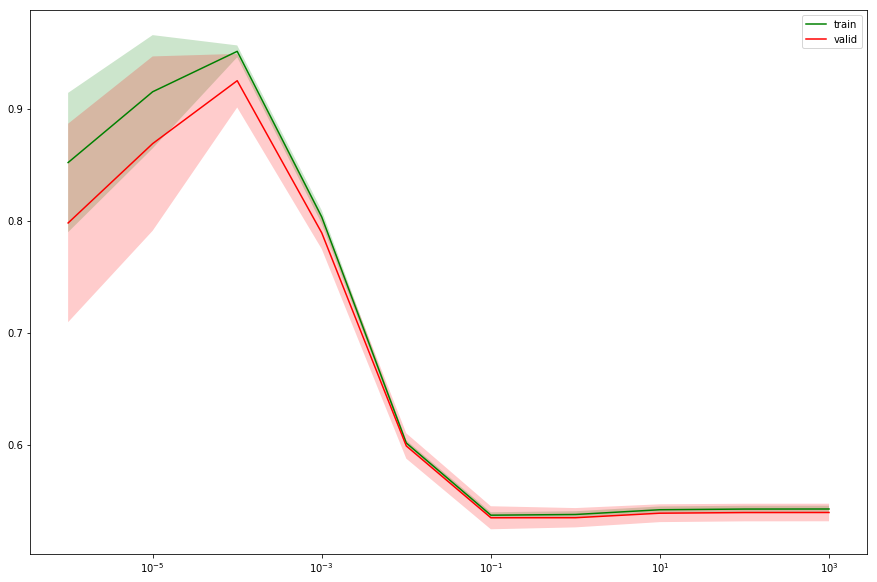

In [25]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, 3, 10)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=tss, n_jobs=-1)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

*Переберем параметры в более подходящем промежутке:*

Best params: alpha = 4.89390091848e-05, score (roc auc) = 0.931012189493
Test score (roc auc) = 0.9448862293054696
valid_std: 0.0246050880486
Wall time: 7.83 s


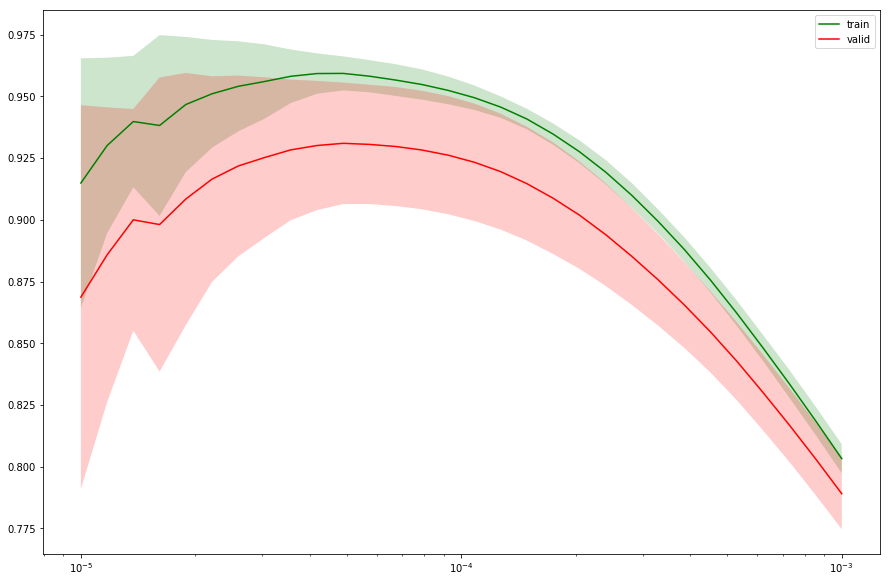

In [26]:
%%time
sgd_logit_params = {'alpha': np.logspace(-5, -3, 30)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=tss, n_jobs=-1)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

*Результат улучшился. Сохраним его:*

In [27]:
logit_test_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'SGDClassifier_GridSearch.csv'))

*Результат на публичном лидерборде на kaggle: 0.90909. Немного хуже бейзлайна без подбора параметров, что несколько странно.*

### SGDClassifier + фичи с недели 3

*С недели 3 взяты лишь некоторые фичи, из них выбраны только те, с которыми качество на обучающей выборке заметно выросло (остальные закомменчены).*

In [28]:
# OneHotEncoder converts integer categories to float, and it affects get_feature_names method (output is like 'hour_7.0')
# this wrapper class is to fix that behaviour
class OneHotEncoderFixed(OneHotEncoder):
    def fit_transform(self, X, y=None):
        X_out = super(OneHotEncoder, self).fit_transform(X, y)
        self.categories_ = [cat.astype(X.dtype) for cat in self.categories_]
        return X_out

In [29]:
def get_session_timespan_log(row):
    row_ne = row[~np.isnat(row)]
    result = int((row_ne[-1]-row_ne[0]) / np.timedelta64(1, 's'))
    return np.log(result) if result > 0 else 0

def count_unique_sites(row):
    row_unique = np.unique(row)
    return len(row_unique[row_unique != 0]) #0 is not a valid site ID

def add_features(X_sites, X_times):
    X = sparsify_data(X_sites)
    site_columns = [col for col in X_sites.columns if col.startswith('site')]
    
    features = []
    cat_features = []
    
    # session_timespan_log
    #features.append( X_times.apply(get_session_timespan_log, raw=True, axis=1) )
    
    # start_hour (one-hot encoded) 
    start_hour = X_times['time1'].dt.hour
    start_hour_encoder = OneHotEncoderFixed(sparse=True, dtype=np.int16)
    cat_features.append( start_hour_encoder.fit_transform(start_hour[:, np.newaxis]) )
    
    # timeofday (one-hot encoded)
    timeofday = np.mod(start_hour + 2, 24) // 6
    timeofday_encoder = OneHotEncoderFixed(sparse=True, dtype=np.int16)
    cat_features.append( timeofday_encoder.fit_transform(timeofday[:, np.newaxis]) )
    
    # dayofweek (one-hot encoded)
    dayofweek = X_times['time1'].dt.dayofweek
    dayofweek_encoder = OneHotEncoderFixed(sparse=True, dtype=np.int16)
    cat_features.append( dayofweek_encoder.fit_transform(dayofweek[:, np.newaxis]) )
    
    # weekend
    features.append( (dayofweek >= 5).astype(int) )
    
    # #unique_sites
    #features.append( X_sites[site_columns].apply(count_unique_sites, raw=True, axis=1) )
    
    features = [np.array(features).transpose()] if features != [] else []
    X = csr_matrix(shstack([X] + features + cat_features))
    
    return X

In [30]:
%%time
train_test_df_times = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(np.datetime64('NaT')).astype(np.datetime64)
train_test_df_with_features = add_features(train_test_df_sites, train_test_df_times)

X_train_sparse = train_test_df_with_features[:len(train_df)]
X_test_sparse = train_test_df_with_features[len(train_df):]
y = train_df['target'].values

train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

Wall time: 3.55 s


In [31]:
tss = TimeSeriesSplit(n_splits=5)

Best params: alpha = 0.0001, score (roc auc) = 0.971878476466
Test score (roc auc) = 0.9730104459119213
valid_std: 0.00875890608216
Wall time: 8.79 s


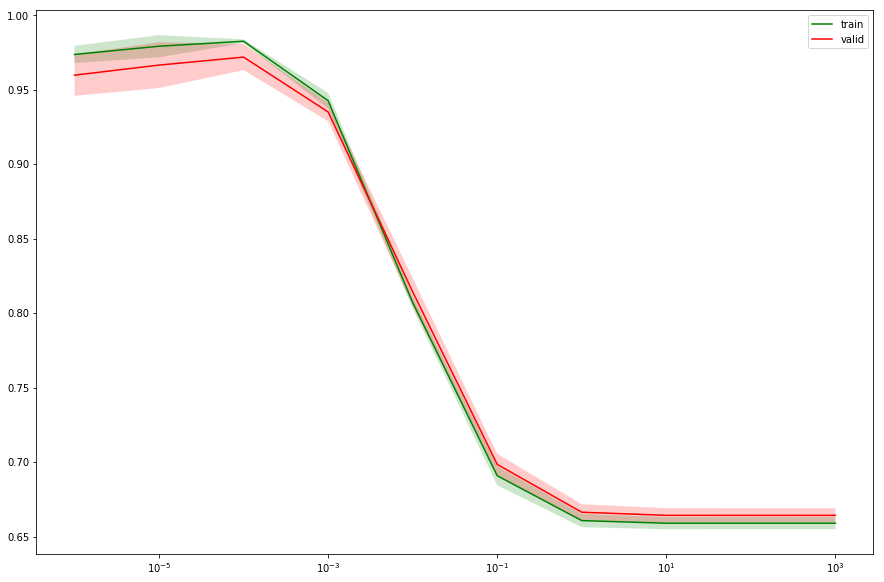

In [32]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, 3, 10)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=tss)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

*Переберем параметры в более подходящем промежутке:*

Best params: alpha = 5.73615251045e-05, score (roc auc) = 0.973292739429
Test score (roc auc) = 0.9766406374554542
valid_std: 0.0115524529978
Wall time: 25.7 s


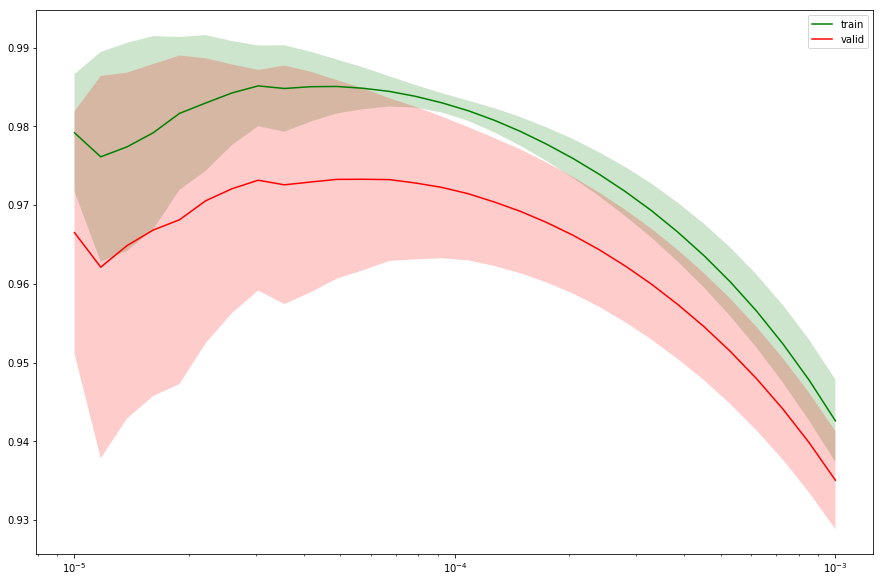

In [33]:
%%time
sgd_logit_params = {'alpha': np.logspace(-5, -3, 30)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=tss)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

*Результат немного улучшился, но стандартное отклонение в этой точке сильно больше, чем при $\alpha = 10^{-4}$. К тому же имеется неестественный пик. Переобучим модель с $\alpha = 8 \cdot 10^{-5}$:*

In [34]:
sgd_logit = SGDClassifier(loss='log', random_state=17, alpha=8e-5)
sgd_logit.fit(X_train, y_train)

logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'SGDClassifier_GridSearch_4feat.csv'))

*Результат на публичном лидерборде на kaggle: 0.94186. Побиты оба требуемых бенчмарка.*

### Бенчмарки с публичного лидерборда на kaggle

* `sgd_logit_benchmark.csv` - 0.91273
* `Logit +3 features` - 0.92784

**Название команды на kaggle:**

**\[YDF & MIPT\] Coursera_Alex Galak**

# Дополнительный анализ признаков

In [35]:
class MarkovChainWithUnknownState():
    def __init__(self):
        self.probs_single = {}
        self.probs = {}
        self.unknown_probs = {}
        self.unknown_prob_single = 0
    
    def fit(self, X):
        #count bigrams in a shape of dict of dicts
        for sequence in X:
            for word1, word2 in zip(sequence[:-1], sequence[1:]):
                if word1 not in self.probs:
                    self.probs[word1] = {}
                if word2 not in self.probs[word1]:
                    self.probs[word1][word2] = 1
                else:
                    self.probs[word1][word2] += 1
        #for each word1
        #normalize counts into probabilities so that the probability of an unknown word2 were included and equal to 1/(total+1)
        totals = {word1: sum(self.probs[word1].values()) for word1 in self.probs}
        for word1 in self.probs:
            for word2 in self.probs[word1]:
                self.probs[word1][word2] /= (totals[word1] + 1)
            self.unknown_probs[word1] = 1 / (totals[word1] + 1)
        #set normalized probs_single and unknown_prob_single - probabilities to observe a single state
        for word1 in totals:
            self.probs_single[word1] = totals[word1] / (sum(totals.values()) + sum(self.unknown_probs.values()))
        self.unknown_prob_single = sum(self.unknown_probs.values()) / (sum(totals.values()) + sum(self.unknown_probs.values()))
    
    def predict_proba(self, X):
        result = []
        for sequence in X:
            subresult = 0
            #probability of the first word
            if sequence[0] not in self.probs_single:
                subresult += np.log(self.unknown_prob_single)
            else:
                subresult += np.log(self.probs_single[sequence[0]])
            #transition probabilities
            for word1, word2 in zip(sequence[:-1], sequence[1:]):
                if word1 not in self.probs:
                    #if word1 is unknown, probability word1 -> word2 is uniformly distributed 
                    #over known words (only word1 are counted) + one unknown word
                    subresult += np.log(1 / (len(self.probs) + 1))
                elif word2 not in self.probs[word1]:
                    #if word2 is unknown, get probability from self.unknown_probs
                    subresult += np.log(self.unknown_probs[word1])
                else:
                    subresult += np.log(self.probs[word1][word2])
            result.append(subresult)
        return result

In [69]:
def get_session_timespan(row):
    row_ne = row[~np.isnat(row)]
    return int((row_ne[-1]-row_ne[0]) / np.timedelta64(1, 's'))

def count_unique_sites(row):
    row_unique = np.unique(row)
    return len(row_unique[row_unique != 0]) #0 is not a valid site ID

def count_popular_sites(sites_df, popular_sites_indicators):
    result = []
    for sites_row, popular_sites_mask in zip(sites_df.values, popular_sites_indicators):
        popular_sites = sites_row[popular_sites_mask]
        result.append( len(np.unique(popular_sites)) )
    return result

def compute_time_on_popular_sites(time_diffs_df, popular_sites_indicators):
    result = []
    for time_diffs_row, popular_sites_mask in zip(time_diffs_df.values, popular_sites_indicators):
        popular_site_times = time_diffs_row[popular_sites_mask[:-1]] #we don't have a time diff for the last site
        popular_site_times = popular_site_times[~np.isnan(popular_site_times)]
        result.append( int(np.sum(popular_site_times)) )
    return result

def compute_site_times(sites_df, time_diffs_df):
    result = []
    for sites_row, times_row in zip(sites_df.values[:, :-1], time_diffs_df.values): #we don't have a time diff for the last site
        subresult = {}
        for site, time in zip(sites_row, times_row):
            if not np.isnan(time):
                if site not in subresult:
                    subresult[site] = time
                else:
                    subresult[site] += time
        result.append(subresult)
    return result

def compute_max_site_time(site_times):
    return [int(np.max(session_site_times.values())) if len(session_site_times.values()) != 0 else 0 
            for session_site_times in site_times]

def compute_avg_site_time(site_times):
    return [np.mean(session_site_times.values()) if len(session_site_times.values()) != 0 else 0 
            for session_site_times in site_times]

def max_with_default(row, default=0):
    row_ne = row[~np.isnan(row)]
    if len(row_ne) == 0:
        return default
    else:
        return int(np.max(row_ne))

def avg_with_default(row, default=0):
    row_ne = row[~np.isnan(row)]
    if len(row_ne) == 0:
        return default
    else:
        return np.mean(row_ne)

def make_features(sessions_df, times_df, verbose=False):
    if verbose: print('Adding features:')
    features_df = pd.DataFrame(index=sessions_df.index)
    #old features
    site_columns = [col for col in sessions_df.columns if col.startswith('site')]
    
    if verbose: print('session_timespan')
    features_df['session_timespan'] = times_df.apply(get_session_timespan, raw=True, axis=1)
    
    if verbose: print('#unique_sites')
    features_df['#unique_sites'] = sessions_df[site_columns].apply(count_unique_sites, raw=True, axis=1)
    
    if verbose: print('start_hour')
    features_df['start_hour'] = times_df['time1'].dt.hour
    
    if verbose: print('day_of_week')
    features_df['day_of_week'] = times_df['time1'].dt.dayofweek
    
    #new features
    time_diffs_df = pd.DataFrame(index=times_df.index)
    for i in range(1, 9+1):
        time_diffs_df['diff{}'.format(i)] = (times_df['time{}'.format(i+1)] - 
                                             times_df['time{}'.format(i)]) / np.timedelta64(1, 's')
    site_counts = zip(*np.unique(sessions_df.values, return_counts=True))[1:]
    popular_sites = zip(*sorted(site_counts, key=lambda t: -t[1])[:30])[0]
    popular_sites_indicators = np.isin(sessions_df[site_columns].values, popular_sites)
    site_times = compute_site_times(sessions_df[site_columns], time_diffs_df)
        
    if verbose: print('year')
    features_df['year'] = times_df['time1'].dt.year
    
    if verbose: print('month')
    features_df['month'] = times_df['time1'].dt.month
    
    if verbose: print('day')
    features_df['day'] = times_df['time1'].dt.day
    
    if verbose: print('time_of_day')
    features_df['time_of_day'] = np.mod(features_df['start_hour'] + 2, 24) // 6
    
    if verbose: print('weekend')
    features_df['weekend'] = (features_df['day_of_week'] >= 5).astype(int)
    
    if verbose: print('max_delay')
    features_df['max_delay'] = time_diffs_df.apply(lambda row: max_with_default(row, 0), raw=True, axis=1)
    
    if verbose: print('avg_delay')
    features_df['avg_delay'] = time_diffs_df.apply(lambda row: avg_with_default(row, 0), raw=True, axis=1)
    
    if verbose: print('max_time')
    features_df['max_time'] = compute_max_site_time(site_times)
    
    if verbose: print('avg_time')
    features_df['avg_time'] = compute_avg_site_time(site_times)
    
    if verbose: print('#popular_sites')
    features_df['#popular_sites'] = count_popular_sites(sessions_df[site_columns], popular_sites_indicators)
    
    if verbose: print('%popular_sites')
    features_df['%popular_sites'] = features_df['#popular_sites'] / features_df['#unique_sites']
    
    if verbose: print('time_popular_sites')
    features_df['time_popular_sites'] = compute_time_on_popular_sites(time_diffs_df, popular_sites_indicators)
    
    if verbose: print('%time_popular_sites')
    features_df['%time_popular_sites'] = features_df['time_popular_sites'] / features_df['session_timespan']
    features_df['%time_popular_sites'] = features_df['%time_popular_sites'].fillna(0) #session timespan might be zero
    
    #for i in tqdm(range(1, 30+1), 
    #              desc='Popular site indicators'):
    #    sessions_df['popular_site{}'.format(i)] = SparseArray(sessions_df[site_columns].apply(
    #        lambda row: int(np.isin(popular_sites[i-1], row)), raw=True, axis=1))
    
    #if verbose: print('#facebook')
    #features_df['#facebook'] = sessions_df[site_columns].apply(lambda row: np.sum((row == 5).astype(int)), 
    #                                                           raw=True, axis=1) # facebook id: 5
    
    #if verbose: print('mc')
    #mc = MarkovChainWithUnknownState()
    #sessions_raveled = sessions_df[:len(y)][y == 1].values.ravel()
    #sessions_raveled = [sessions_raveled[sessions_raveled != 0]]
    #mc.fit(sessions_raveled)
    ##features_df['mc'] = mc.predict_proba([row[row != 0] for row in sessions_df[site_columns].values])
    #features_df['mc'] = mc.predict_proba(sessions_df[site_columns].values)
    
    
    #move target column to the end
    #target = sessions_df['target']
    #del sessions_df['target']
    #sessions_df['target'] = target
    return features_df

def prepare_features(features_df):
    cat_features = ['start_hour', 'day_of_week', 'year', 'month', 'day', 'time_of_day']
    features_to_log = ['session_timespan']
    features_to_scale = ['#unique_sites']
    features_unmodified = ['weekend', '%popular_sites', '%time_popular_sites']
    #skipped features: max_delay, avg_delay, max_time, avg_time, time_popular_sites, #popular_sites
    
    cat_encoder = OneHotEncoderFixed(sparse=True, dtype=np.int16)
    cat_features_encoded = cat_encoder.fit_transform(features_df[cat_features].values)
    result = cat_features_encoded
    feature_names = list(cat_encoder.get_feature_names(cat_features))
    
    scaled_features = np.hstack([np.log(features_df[features_to_log].values + 1), 
                                 features_df[features_to_scale].values])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(scaled_features)
    
    result = csr_matrix(shstack([result, 
                                 scaled_features, 
                                 features_df[features_unmodified].values]))
    feature_names = feature_names + features_to_log + features_to_scale + features_unmodified
    
    return result, feature_names

In [70]:
%%time
train_test_features = make_features(train_test_df_sites, train_test_df_times)
train_features = train_test_features[:len(train_df)]
alice_train_features = train_features[y == 1]
non_alice_train_features = train_features[y == 0]

Wall time: 24.9 s


In [71]:
sgd_logit_predictions = sgd_logit.predict(X_train_sparse)
false_positive = train_features[(sgd_logit_predictions == 1) & (y == 0)]
false_negative = train_features[(sgd_logit_predictions == 0) & (y == 1)]

In [80]:
def plot_feature_hist(feature, bins=None, apply_func=lambda x: x):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    
    ax = axes[0, 0]
    alice_train_features[feature].apply(apply_func).hist(bins=bins, ax=ax)
    ax.set_title('Alice')
    ax.set_xlabel(feature)
    
    ax = axes[0, 1]
    non_alice_train_features[feature].apply(apply_func).hist(bins=bins, ax=ax, color='green')
    ax.set_title('Not Alice')
    ax.set_xlabel(feature)
    
    ax = axes[1, 0]
    false_negative[feature].apply(apply_func).hist(bins=bins, ax=ax)
    ax.set_title('Alice errors')
    ax.set_xlabel(feature)
    
    ax = axes[1, 1]
    false_positive[feature].apply(apply_func).hist(bins=bins, ax=ax, color='green')
    ax.set_title('Not Alice errors')
    ax.set_xlabel(feature)  

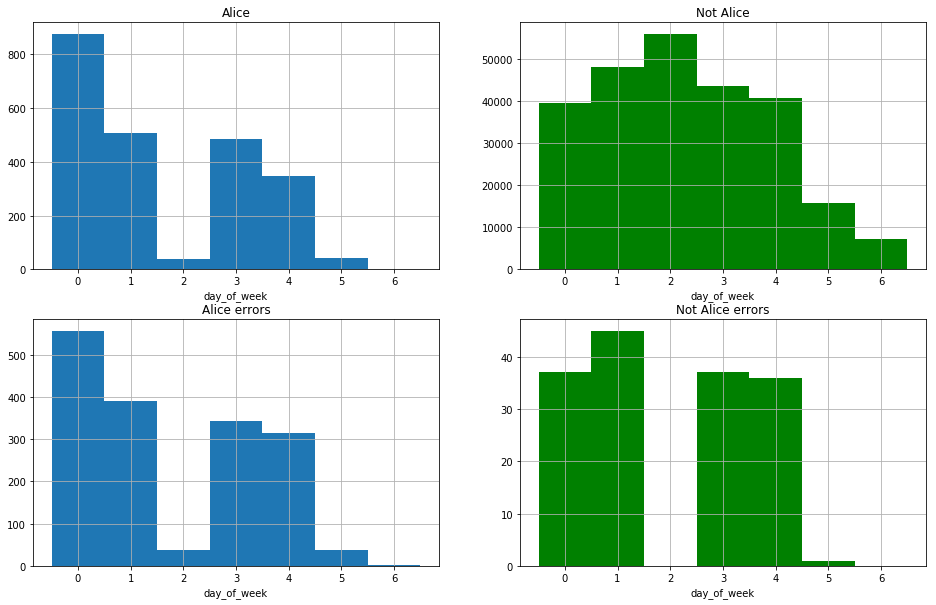

In [81]:
plot_feature_hist('day_of_week', np.linspace(0-0.5, 6+0.5, 7+1))

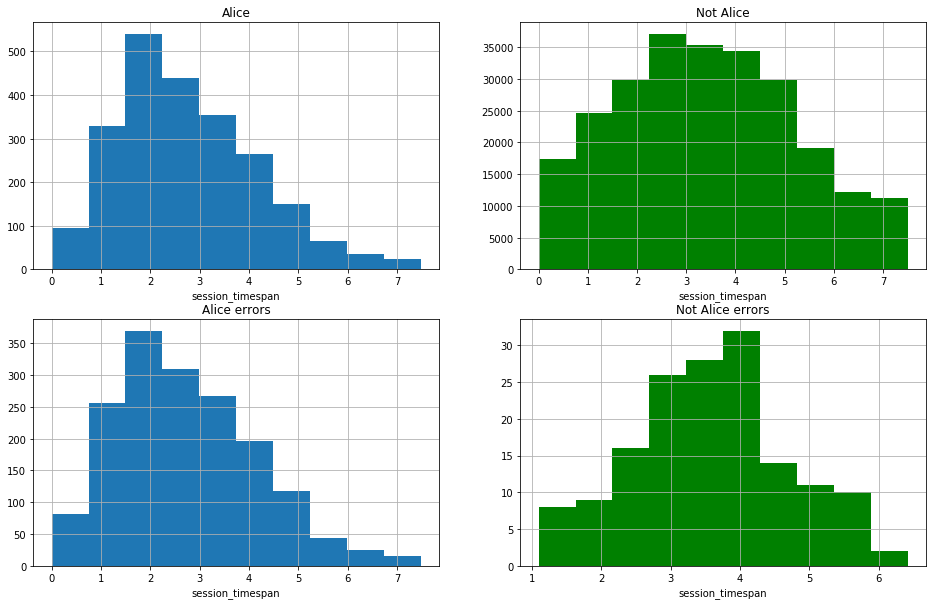

In [82]:
plot_feature_hist('session_timespan', apply_func=lambda x: np.log(x+1))

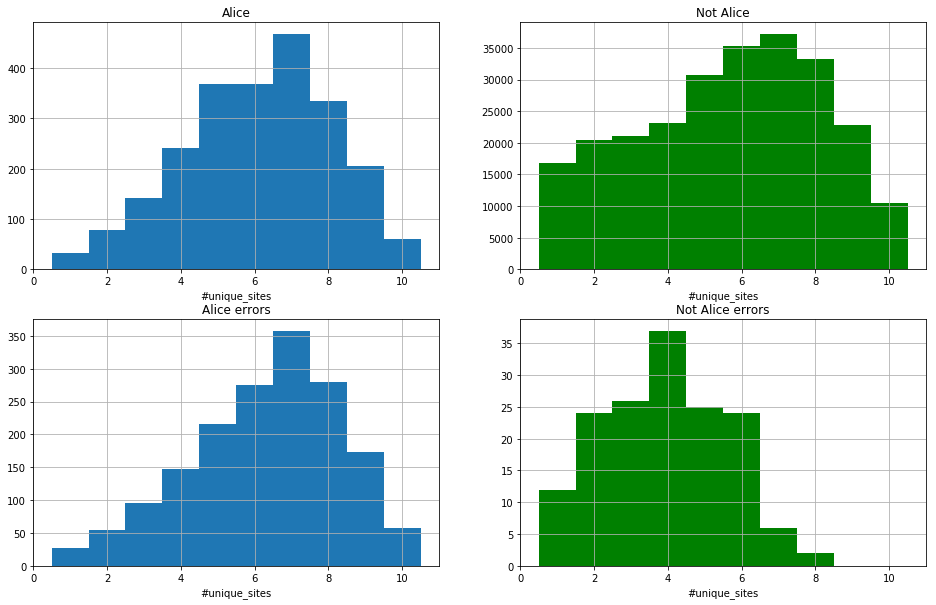

In [83]:
plot_feature_hist('#unique_sites', np.linspace(1-0.5, 10+0.5, 10+1))

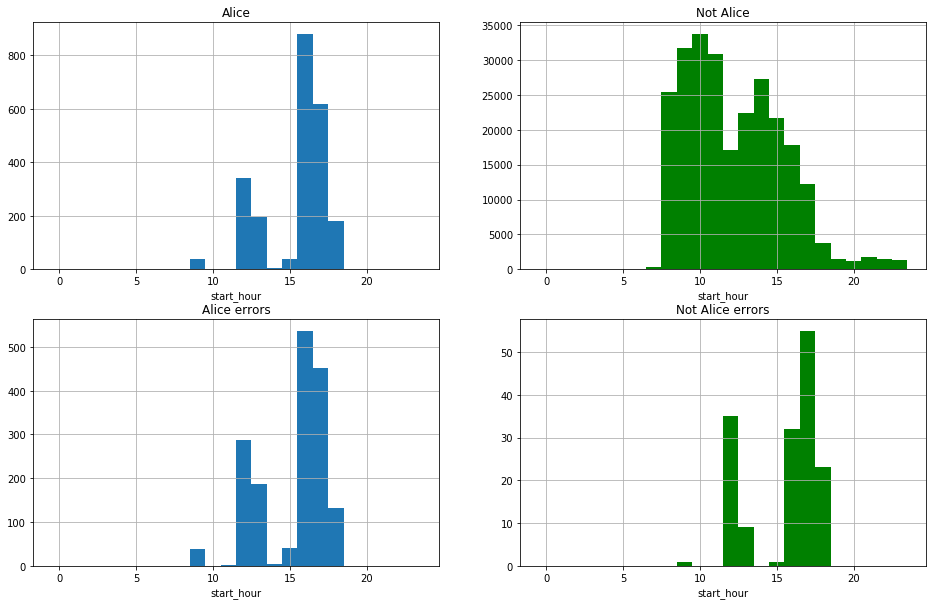

In [76]:
plot_feature_hist('start_hour', np.linspace(0-0.5, 23+0.5, 24+1))

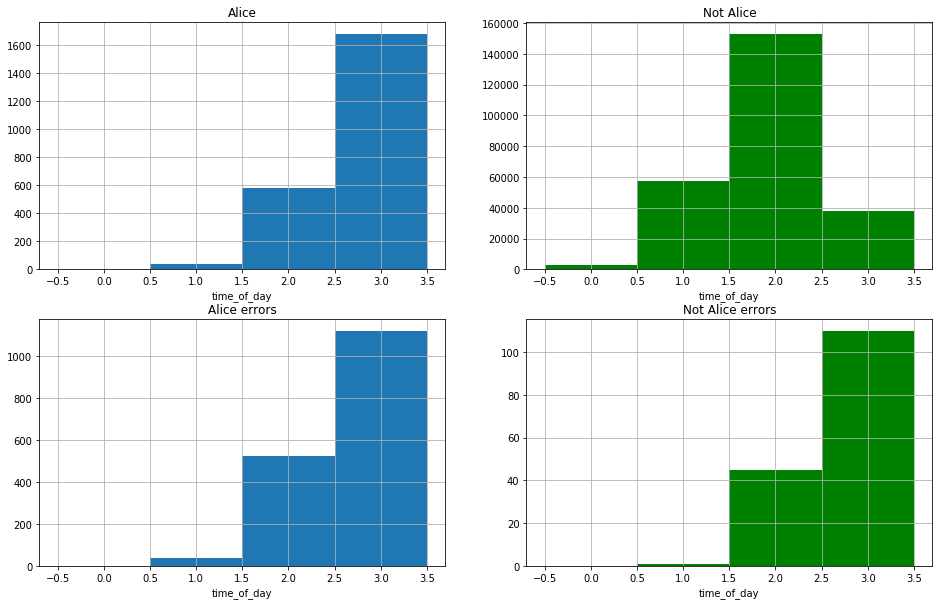

In [79]:
plot_feature_hist('time_of_day', np.linspace(0-0.5, 3+0.5, 4+1))

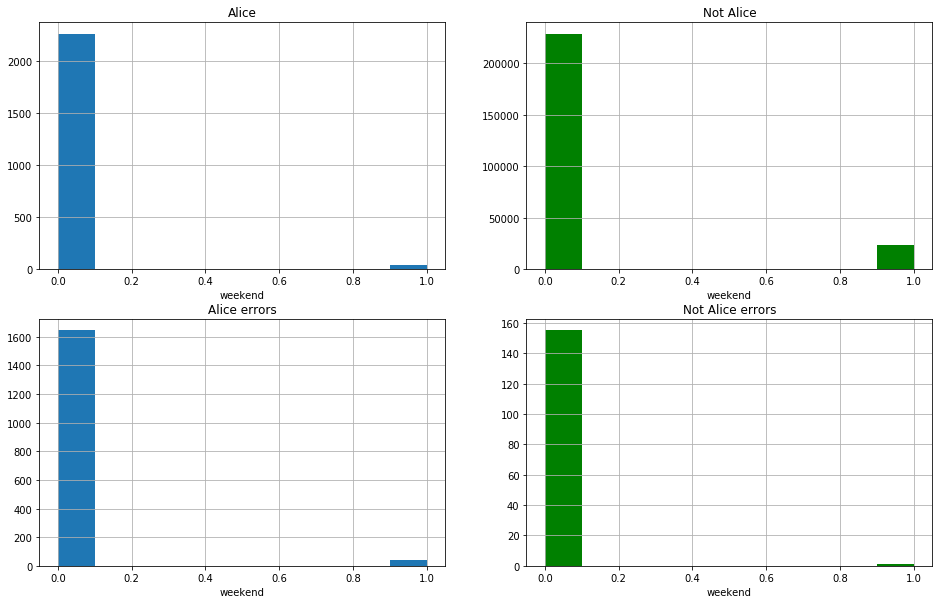

In [77]:
plot_feature_hist('weekend')

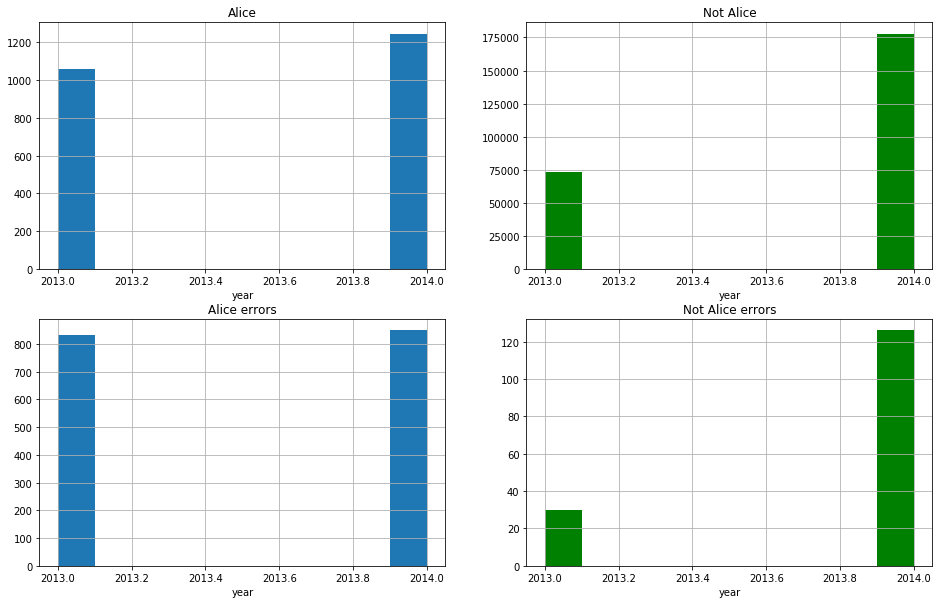

In [78]:
plot_feature_hist('year')

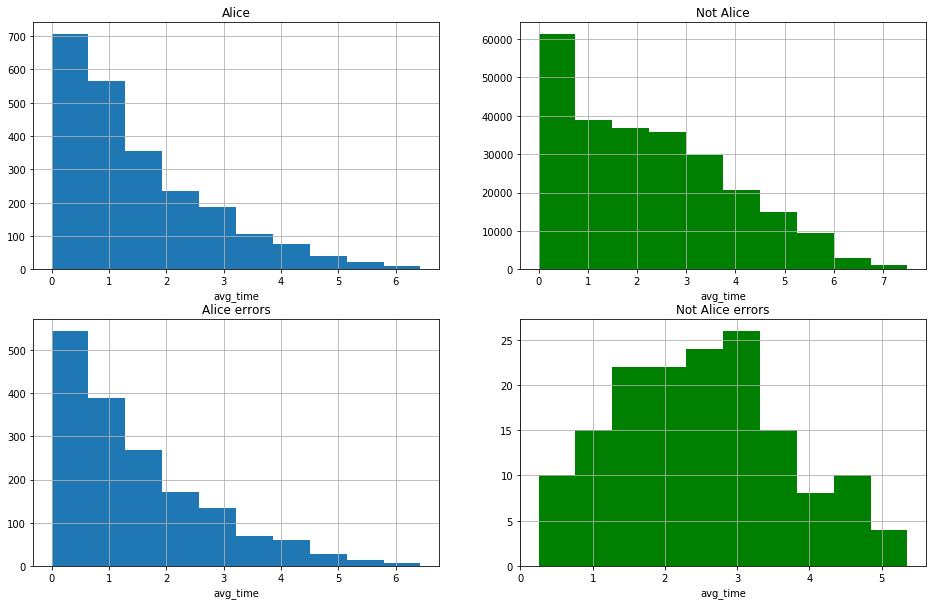

In [89]:
plot_feature_hist('avg_time', apply_func=lambda x: np.log(x+1))

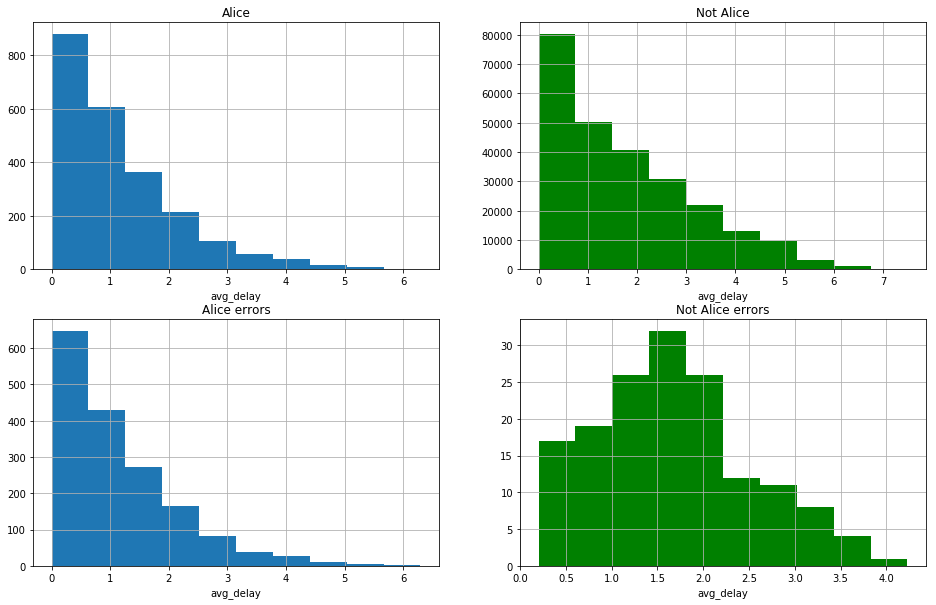

In [94]:
plot_feature_hist('avg_delay', apply_func=lambda x: np.log(x+1))

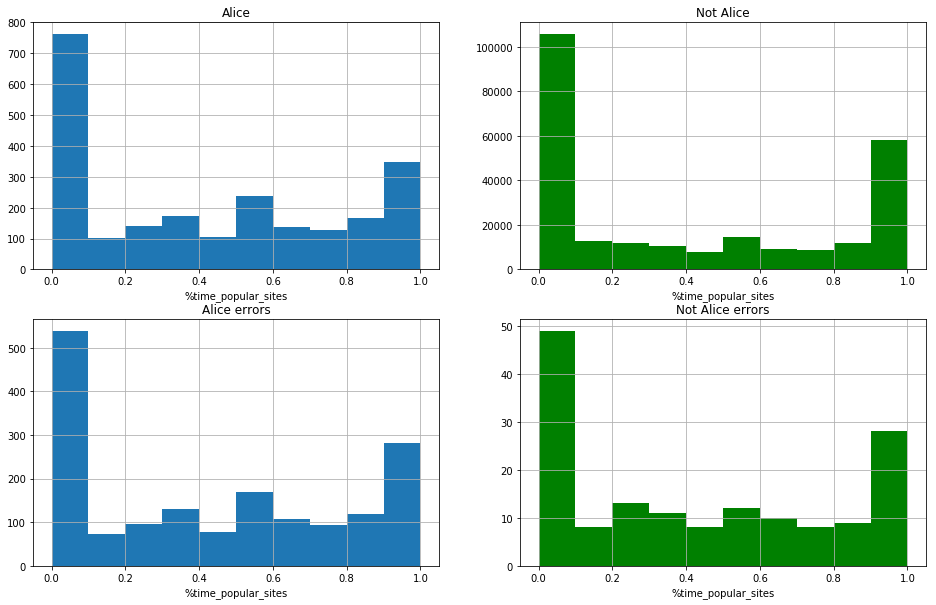

In [96]:
plot_feature_hist('%time_popular_sites')

---

---

In [43]:
%%time
train_test_df_times = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(np.datetime64('NaT')).astype(np.datetime64)
train_test_features, feature_names = prepare_features(make_features(train_test_df_sites, 
                                                                    train_test_df_times))

Wall time: 42 s


In [44]:
%%time
selector_model = RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)
feature_selector = BorutaPy(selector_model, n_estimators='auto', verbose=2, max_iter=25, random_state=17)
feature_selector.fit(train_test_features[:len(train_df)].toarray(), y)
train_test_features_selected = feature_selector.transform(train_test_features)
feature_names_selected = feature_selector.transform(np.array([feature_names]))[0]
print('Dropped features: {}'.format( list(set(feature_names) - set(feature_names_selected)) ))

train_test_with_features = csr_matrix(shstack([sparsify_data(train_test_df_sites), train_test_features_selected]))

Iteration: 	1 / 25
Confirmed: 	0
Tentative: 	72
Rejected: 	0
Iteration: 	2 / 25
Confirmed: 	0
Tentative: 	72
Rejected: 	0
Iteration: 	3 / 25
Confirmed: 	0
Tentative: 	72
Rejected: 	0
Iteration: 	4 / 25
Confirmed: 	0
Tentative: 	72
Rejected: 	0
Iteration: 	5 / 25
Confirmed: 	0
Tentative: 	72
Rejected: 	0
Iteration: 	6 / 25
Confirmed: 	0
Tentative: 	72
Rejected: 	0
Iteration: 	7 / 25
Confirmed: 	0
Tentative: 	72
Rejected: 	0
Iteration: 	8 / 25
Confirmed: 	50
Tentative: 	12
Rejected: 	10
Iteration: 	9 / 25
Confirmed: 	50
Tentative: 	12
Rejected: 	10
Iteration: 	10 / 25
Confirmed: 	50
Tentative: 	12
Rejected: 	10
Iteration: 	11 / 25
Confirmed: 	50
Tentative: 	12
Rejected: 	10
Iteration: 	12 / 25
Confirmed: 	52
Tentative: 	10
Rejected: 	10
Iteration: 	13 / 25
Confirmed: 	52
Tentative: 	10
Rejected: 	10
Iteration: 	14 / 25
Confirmed: 	52
Tentative: 	10
Rejected: 	10
Iteration: 	15 / 25
Confirmed: 	52
Tentative: 	9
Rejected: 	11
Iteration: 	16 / 25
Confirmed: 	52
Tentative: 	9
Rejected: 	11
I

In [45]:
X_train_sparse = train_test_with_features[:len(train_df)]
X_test_sparse = train_test_with_features[len(train_df):]
y = train_df['target'].values

train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [46]:
tss = TimeSeriesSplit(n_splits=5)

Best params: alpha = 0.0001, score (roc auc) = 0.978815467305
Test score (roc auc) = 0.9802079466291254
valid_std: 0.00766123188294
Wall time: 9.25 s


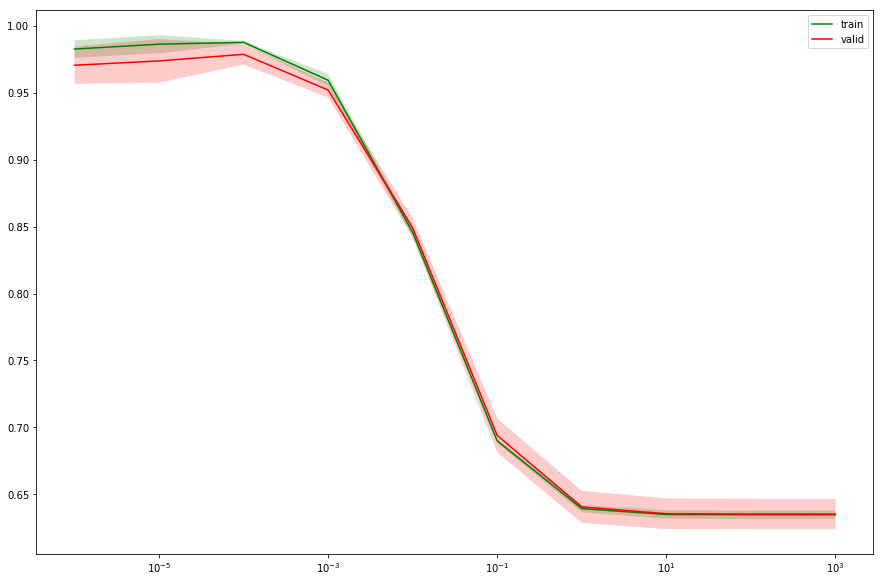

In [47]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, 3, 10)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=tss)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

Best params: alpha = 4.17531893656e-05, score (roc auc) = 0.980594669174
Test score (roc auc) = 0.9845503193542502
valid_std: 0.0105423691178
Wall time: 28 s


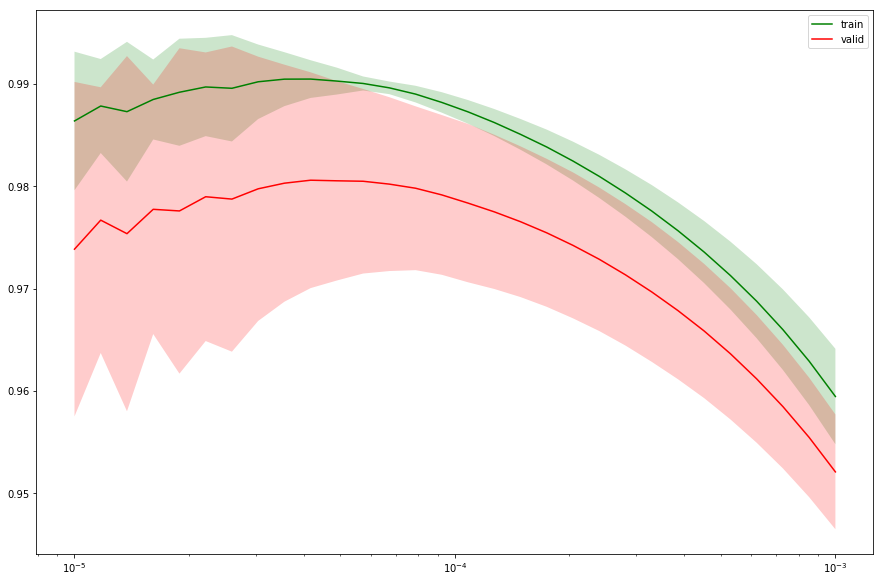

In [48]:
%%time
sgd_logit_params = {'alpha': np.logspace(-5, -3, 30)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=tss)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

In [53]:
dict(zip(feature_names_selected, 
         sgd_logit_grid_searcher.best_estimator_.coef_[0][-len(feature_names_selected):].tolist()))

{u'#unique_sites': 0.4560032139039765,
 u'%popular_sites': -0.24995390060866082,
 u'%time_popular_sites': -0.01859148545547091,
 u'day_12': -1.46127431060078,
 u'day_13': 0.6833700986117679,
 u'day_14': 0.035215501406834215,
 u'day_15': 1.0456087408113195,
 u'day_19': 0.6532056206349586,
 u'day_2': 1.5210765826158439,
 u'day_20': -0.29490884713069804,
 u'day_21': -2.1049294506746206,
 u'day_22': 0.3430840332164577,
 u'day_24': 0.4930168327808874,
 u'day_25': 0.13841584381964808,
 u'day_26': -1.0637667734755127,
 u'day_27': -0.8049390003519802,
 u'day_28': -0.6635139998146228,
 u'day_29': 1.0414174106594942,
 u'day_3': -0.8379228858322925,
 u'day_31': -0.7665566187532832,
 u'day_4': -0.4269083913265054,
 u'day_of_week_0': 0.4630522859040598,
 u'day_of_week_1': -0.26363708633044325,
 u'day_of_week_2': -2.6388801496905145,
 u'day_of_week_3': -1.045472056428097,
 u'day_of_week_4': -0.42449395785810445,
 u'day_of_week_5': 0.07097573415428181,
 u'day_of_week_6': -1.2315900493568475,
 u'month

In [50]:
sgd_logit = SGDClassifier(loss='log', random_state=17, alpha=8e-5)
sgd_logit.fit(X_train, y_train)

logit_test_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'SGDClassifier_GridSearch_allfeat.csv'))

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`). Это только в случае, если вы проходите специализацию.
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям, отделив одного из пользователей от остальных – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов, также хороша [статья](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending) Александра Дьяконова
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных веб-страницах Элис и остальными 1557 пользователями (*train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.